In [15]:
 import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [2]:
def bs_price(S,K,sigma,r,T, year_rate = 252, option_type = "call"):
    '''
    bs 期权定价 输出为期权价格
    输入格式：
    S:标的价格
    K:行权价
    sigma:波动率
    r:无风险利率
    T:年华剩余期限
    year_rate:年化系数
    '''

    T = T/year_rate
    d1 = (np.log(S/K) + (r + pow(sigma,2)/2)*T) / (sigma*np.sqrt(T)) 
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        # return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        return np.maximum(S - K, 0) if T==0 else S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option_type == 'put':
        # return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
        return np.maximum(K-S,0) if T==0 else K*np.exp(-r*T)*norm.cdf(-1*d2) - S*norm.cdf(-1*d1)
    else:
        print("期权类型错误")
        return -1

def bs_vega(S,K,sigma,r,T ,year_rate = 252):
    '''
    计算vega
    '''
    T = T/year_rate
    d1 = (np.log(S/K) + (r + pow(sigma,2)/2)*T) / (sigma*np.sqrt(np.abs(T)) )
    return S*norm.pdf(d1)*np.sqrt(np.abs(T))
    # return S * np.sqrt(abs(T)) * np.exp(-pow(d1,2)/2) / np.sqrt(2*np.pi)

def iv_bs_bisection(S, K, r, T, price, option_type, iv_uplimit = 1.0, iv_downlimit = 0.01, precision = 3, year_rate = 365, max_iterations = 200):
    '''二分法求iv'''
    left_iv, right_iv = iv_downlimit, iv_uplimit
    # left_price = BS_price(S,K,left_iv, r, T,  year_rate = year_rate, option_type = option_type)
    # right_price= BS_price(S,K,right_iv, r, T,  year_rate = year_rate, option_type = option_type)
    mid_iv = (left_iv + right_iv)/2
    mid_price = bs_price(S,K,mid_iv, r, T,  year_rate = year_rate, option_type = option_type)
    # print(f"first, the mid price is {mid_price}, the price is {price}")
    cnt = 0
    while abs(price - mid_price) >= 0.1**precision and cnt < max_iterations:
        if mid_price < price :
            left_iv = mid_iv
        else:
            right_iv = mid_iv
        mid_iv = (left_iv + right_iv)/2
        # if mid_iv < iv_uplimit or mid_iv > iv_downlimit:
        #     break
        # print(f"cnt = {cnt}, the left is{left_iv}, the right is{right_iv}, the mid is {mid_iv}")
        cnt += 1
        mid_price = bs_price(S,K,mid_iv, r, T,  year_rate = year_rate, option_type = option_type)
    return mid_iv

def find_vol_newton( S, K, r, T, target_value, option_type, start_sigma = 0.5, precision = 3, year_rate = 252, max_iterations = 200):
    '''迭代法求iv'''
    sigma = start_sigma
    for i in range(0, max_iterations):
        bs_price_ = bs_price(S,K,sigma,r,T, year_rate = year_rate, option_type = option_type)
        vega = bs_vega(S, K, T, r, sigma, year_rate = year_rate)*100
        diff = target_value - bs_price_  # our root
        if (abs(diff) < 0.1**precision):
            return sigma
        sigma = sigma + diff/(vega) # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

def change(type_name):
    if type_name == 1:
        return "call"
    elif type_name == 0:
        return "put"
    else:
        return "wrong_type"

In [ ]:
# 新的计算方式

def implied_volatility(S, K, T, r, C):
    # S is the current stock price
    # K is the strike price
    # T is the time to maturity
    # r is the risk-free rate
    # C is the option price
    # Initialize the implied volatility
    implied_vol = 0.2
    # Set the tolerance
    tol = 0.00001
    # Set the maximum number of iterations
    max_iter = 100
    # Set the initial difference between the option price and the Black-Scholes price
    diff = 1.0
    # Set the iteration counter
    iter = 0
    # Start the loop
    while (diff > tol) and (iter < max_iter):
        # Calculate the Black-Scholes price
        d1 = (np.log(S/K) + (r + 0.5*implied_vol**2)*T) / (implied_vol*np.sqrt(T))
        d2 = d1 - implied_vol*np.sqrt(T)
        bs_price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        # Calculate the difference between the option price and the Black-Scholes price
        diff = np.abs(C - bs_price)
        # Calculate the implied volatility
        implied_vol = implied_vol + 0.1*diff
        # Increment the iteration counter
        iter = iter + 1
    # Return the implied volatility
    return implied_vol

In [ ]:
import scipy.optimize as opt
def implied_volatility(price, S, K, T, r):
    def f(sigma):
        d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return (price - S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)) ** 2
    opt_result = opt.minimize(f, 0.2, method='Nelder-Mead')
    return opt_result.x[0]

In [45]:
iv_bs_bisection(3.32, 3.4, 0.018,73, 0.33, 'call')

0.6083398558139801

In [46]:
find_vol_newton(3.32, 3.4, 0.018,73, 0.33, 'call')

0.6083396961968708

In [5]:
'''测试，数据清洗'''
csv_name = 'data/50etf_option_data_csv_cleaned/10000003.csv'
csv_out = 'data/out/10000001.csv'

count = 0
callcount = 0
putcount = 0

data = pd.read_csv(csv_name, encoding = 'utf-8', index_col= False)

data.columns = ['date'] + data.columns[2:].tolist() + ['haha']
data.drop('date', axis = 1, inplace=True)
data['call_or_put'] = data['call_or_put'].apply(change)
data = data[['date','ptmtradeday','exe_price', 'open', 'high','low','close', 'call_or_put']]
data.head()

,date,ptmtradeday,exe_price,open,high,low,close,call_or_put
0,非数字,45,4027.2,0.1364,0.1134,0.1225,1323,put
1,0.1225,44,4209.8,0.1430,0.1167,0.1367,635,put
2,0.1367,43,4219.0,0.1451,0.1280,0.1363,1063,put
3,0.1363,42,4197.8,0.1372,0.1200,0.1323,873,put
4,0.1323,41,4149.0,0.1550,0.1257,0.1281,2851,put


In [4]:
tf50 = pd.read_excel(r'.\data\50etf_df.xlsx')
tf50.columns

Index(['Date', 'pre_close', 'open', 'high', 'low', 'close', 'volume', 'amt',
       'dealnum', 'chg', 'pct_chg', 'swing', 'turn'],
      dtype='object')

In [5]:
data.columns

Index(['Unnamed: 0', 'date', 'pre_close', 'open', 'high', 'low', 'close',
       'volume', 'amt', 'ptmtradeday', 'ptmday', 'delta', 'gamma', 'vega',
       'theta', 'rho', 'us_impliedvol', 'exe_price', 'maint_margin',
       'exe_ratio', 'wind_code', 'trade_coe', 'sec_name', 'option_mark_code',
       'option_type', 'call_or_put', 'exercise_mode', 'exercise_price',
       'contract_unit', 'limit_month', 'listed_date', 'expire_date',
       'exercise_date', 'settlement_date', 'reference_price', 'settle_mode',
       'contract_state'],
      dtype='object')

In [5]:
data["date"] = pd.to_datetime(data["date"])
data = data[['date','ptmtradeday','exe_price', 'open', 'high','low','close', 'call_or_put']]
data.head()

,date,ptmtradeday,exe_price,open,high,low,close,call_or_put
0,2015-02-09,28,2.2,0.1820,0.2029,0.1699,0.1826,1
1,2015-02-10,27,2.2,0.1856,0.2144,0.1800,0.2072,1
2,2015-02-11,26,2.2,0.2083,0.2195,0.2028,0.2107,1
3,2015-02-12,25,2.2,0.2141,0.2143,0.1915,0.2109,1
4,2015-02-13,24,2.2,0.2130,0.2459,0.2090,0.2090,1


In [6]:
data['call_or_put'] = data['call_or_put'].apply(change)
data.head()


C:\fun\annaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,ptmtradeday,exe_price,open,high,low,close,call_or_put
0,2015-02-09,28,2.2,0.1820,0.2029,0.1699,0.1826,call
1,2015-02-10,27,2.2,0.1856,0.2144,0.1800,0.2072,call
2,2015-02-11,26,2.2,0.2083,0.2195,0.2028,0.2107,call
3,2015-02-12,25,2.2,0.2141,0.2143,0.1915,0.2109,call
4,2015-02-13,24,2.2,0.2130,0.2459,0.2090,0.2090,call


In [7]:
rate = pd.read_excel(r".\data\unrisked_rate.xlsx")
rate['date'] = pd.to_datetime(rate['date'])
rate['Value'] = rate['Value']/100
rate.head()

,date,Value
0,2012-10-08,0.035896
1,2012-10-09,0.035942
2,2012-10-10,0.036249
3,2012-10-11,0.036252
4,2012-10-12,0.036240


In [4]:
rate.shape

(2517, 2)

In [8]:
etf50 = pd.read_excel(r'.\data\50etf_df.xlsx')
etf50 = etf50[['Date','close']]
etf50['Date'] = pd.to_datetime(etf50['Date'])
etf50.head()

,Date,close
0,2005-02-23,0.876
1,2005-02-24,0.876
2,2005-02-25,0.880
3,2005-02-28,0.872
4,2005-03-01,0.867


In [6]:
etf50.shape

(4305, 2)

In [10]:
merged_option1 = pd.merge(rate, data, on = 'date', how = 'inner')
merged_option1

,date,Value,ptmtradeday,exe_price,open,high,low,close,call_or_put
0,2015-02-09,0.045769,28,2.2,0.1820,0.2029,0.1699,0.1826,call
1,2015-02-10,0.045696,27,2.2,0.1856,0.2144,0.1800,0.2072,call
2,2015-02-11,0.045715,26,2.2,0.2083,0.2195,0.2028,0.2107,call
3,2015-02-12,0.045540,25,2.2,0.2141,0.2143,0.1915,0.2109,call
4,2015-02-13,0.045669,24,2.2,0.2130,0.2459,0.2090,0.2090,call
5,2015-02-16,0.045716,23,2.2,0.2111,0.2219,0.2066,0.2172,call
6,2015-02-17,0.045626,22,2.2,0.2226,0.2408,0.2226,0.2296,call
7,2015-02-25,0.045924,21,2.2,0.2235,0.2250,0.1816,0.1885,call
8,2015-02-26,0.046345,20,2.2,0.1900,0.2530,0.1730,0.2530,call
9,2015-02-27,0.046482,19,2.2,0.2534,0.2739,0.2431,0.2488,call


In [11]:
merged_option2 = pd.merge(etf50, merged_option1, left_on = 'Date', right_on = 'date', how = 'inner')
merged_option2

,Date,close_x,date,Value,ptmtradeday,exe_price,open,high,low,close_y,call_or_put
0,2015-02-09,2.331,2015-02-09,0.045769,28,2.2,0.1820,0.2029,0.1699,0.1826,call
1,2015-02-10,2.369,2015-02-10,0.045696,27,2.2,0.1856,0.2144,0.1800,0.2072,call
2,2015-02-11,2.380,2015-02-11,0.045715,26,2.2,0.2083,0.2195,0.2028,0.2107,call
3,2015-02-12,2.384,2015-02-12,0.045540,25,2.2,0.2141,0.2143,0.1915,0.2109,call
4,2015-02-13,2.390,2015-02-13,0.045669,24,2.2,0.2130,0.2459,0.2090,0.2090,call
5,2015-02-16,2.394,2015-02-16,0.045716,23,2.2,0.2111,0.2219,0.2066,0.2172,call
6,2015-02-17,2.411,2015-02-17,0.045626,22,2.2,0.2226,0.2408,0.2226,0.2296,call
7,2015-02-25,2.370,2015-02-25,0.045924,21,2.2,0.2235,0.2250,0.1816,0.1885,call
8,2015-02-26,2.450,2015-02-26,0.046345,20,2.2,0.1900,0.2530,0.1730,0.2530,call
9,2015-02-27,2.438,2015-02-27,0.046482,19,2.2,0.2534,0.2739,0.2431,0.2488,call


In [17]:
merged_option2.columns

Index(['Date', 'close_x', 'date', 'Value', 'ptmtradeday', 'exe_price', 'open',
       'high', 'low', 'close_y', 'call_or_put'],
      dtype='object')

In [18]:
merged_option2 = merged_option2[['call_or_put','date','ptmtradeday','exe_price','Value', 'open', 'high','low','close_y','close_x']]
merged_option2.columns = ['call_or_put', 'date','ptmtradeday','k', 'rate', 'open', 'high','low','close','s']
# print(merged_option2.s)
# merged_option2['iv'] = merged_option2.apply(lambda row : iv_bs_bisection(row['s'], row['k'], row['rate'], row['ptmtradeday'], row['close'], row['call_or_put'], iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 6, year_rate = 365),  axis=1)
merged_option2['iv'] = pd.Series
for i in range(merged_option2.shape[1]):
    merged_option2['iv'][i] = iv_bs_bisection(np.array(merged_option2['s'][i]), np.array(merged_option2['k'][i]), np.array(merged_option2['rate'][i]), np.array(merged_option2['ptmtradeday'][i]), np.array(merged_option2['close'][i]), np.array(merged_option2['call_or_put'][i]), iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 6, year_rate = 365, max_iterations= 120)
    # merged_option2['iv'][i] = find_vol_newton(merged_option2['s'][i],merged_option2['k'][i], merged_option2['rate'][i], merged_option2['ptmtradeday'][i], merged_option2['close'][i], merged_option2['call_or_put'][i],start_sigma = 0.1, precision = 3, year_rate = 365.0, max_iterations = 100)
    print(merged_option2['s'][i],merged_option2['k'][i], merged_option2['rate'][i])
    print(merged_option2['iv'][i])
    # break

TypeError: __array__() missing 1 required positional argument: 'self'

In [19]:
#原代码
csv_folder = r'.\data\50etf_option_data_csv_cleaned'
output_folder = r'.\data\out'
csv_list = os.listdir(csv_folder)

for csv_name in csv_list:
    print(csv_name)
    csv_path = csv_folder +"\\"+csv_name
    output_path = output_folder + "\\" + csv_name
    data = pd.read_csv(csv_path, encoding = 'utf-8', index_col= False)
    data.columns = ['data'] + data.columns[2:].tolist() + ['haha']
    data.drop('haha', axis = 1, inplace=True)
    data["date"] = pd.to_datetime(data["date"])
    data = data[['date','ptmtradeday','exe_price', 'open', 'high','low','close', 'call_or_put']]
    data['call_or_put'] = data['call_or_put'].apply(change)
    merged_option1 = pd.merge(rate, data, on = 'date', how = 'inner')
    merged_option2 = pd.merge(etf50, merged_option1, left_on = 'Date', right_on = 'date', how = 'inner')
    merged_option2 = merged_option2[['call_or_put','date','ptmtradeday','exe_price','Value', 'open', 'high','low','close_y','close_x']]
    merged_option2.columns = ['call_or_put', 'date','ptmtradeday','k', 'rate', 'open', 'high','low','close','s']
    # print(merged_option2.s)
    # merged_option2['iv'] = merged_option2.apply(lambda row : iv_bs_bisection(row['s'], row['k'], row['rate'], row['ptmtradeday'], row['close'], row['call_or_put'], iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 6, year_rate = 365),  axis=1)
    merged_option2['iv'] = pd.Series
    for i in range(merged_option2.shape[0]):
        merged_option2['iv'][i] = iv_bs_bisection(np.array(merged_option2['s'][i]), np.array(merged_option2['k'][i]), np.array(merged_option2['rate'][i]), np.array(merged_option2['ptmtradeday'][i]), np.array(merged_option2['close'][i]), np.array(merged_option2['call_or_put'][i]), iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 4, max_iterations= 1000)
        # merged_option2['iv'][i] = find_vol_newton(merged_option2['s'][i],merged_option2['k'][i], merged_option2['rate'][i], merged_option2['ptmtradeday'][i], merged_option2['close'][i], merged_option2['call_or_put'][i],start_sigma = 0.1, precision = 3, year_rate = 365.0, max_iterations = 100)
        print(merged_option2['s'][i],merged_option2['k'][i], merged_option2['rate'][i])
        print(merged_option2['iv'][i])
        # break
    merged_option2.to_csv(output_path)

10000001.csv


TypeError: __array__() missing 1 required positional argument: 'self'

10000001.csv
x []
perdata []


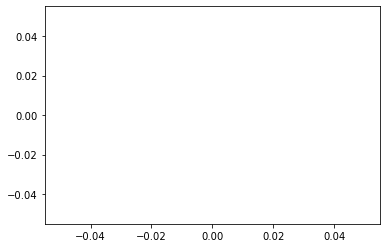

In [10]:
#数据处理
alldata = []
rate = pd.read_excel(r".\data\unrisked_rate.xlsx")
rate['date'] = pd.to_datetime(rate['date'])
rate['Value'] = rate['Value']/100

etf50 = pd.read_excel(r'.\data\50etf_df.xlsx')
etf50 = etf50[['Date','close']]
etf50['Date'] = pd.to_datetime(etf50['Date'])

csv_folder = r'.\data\50etf_option_data_csv_cleaned'
output_folder = r'.\data\out'
csv_list = os.listdir(csv_folder)
picdata = []

for csv_name in csv_list:
    print(csv_name)
    perdata = []
    csv_path = csv_folder +"\\"+csv_name
    output_path = output_folder + "\\" + csv_name
    data = pd.read_csv(csv_path, encoding = 'utf-8', index_col= False)
    data.columns = ['date'] + data.columns[2:].tolist() + ['haha']
    data.drop('haha', axis = 1, inplace=True)
    data["date"] = pd.to_datetime(data["date"])
    data = data[['date','ptmtradeday','exe_price', 'open', 'high','low','close', 'call_or_put']]
    data['call_or_put'] = data['call_or_put'].apply(change)
    merged_option1 = pd.merge(rate, data, on = 'date', how = 'inner')
    merged_option2 = pd.merge(etf50, merged_option1, left_on = 'Date', right_on = 'date', how = 'inner')
    merged_option2 = merged_option2[['call_or_put','date','ptmtradeday','exe_price','Value', 'open', 'high','low','close_y','close_x']]
    merged_option2.columns = ['call_or_put', 'date','ptmtradeday','k', 'rate', 'open', 'high','low','close','s']
    # print(merged_option2.s)
    # merged_option2['iv'] = merged_option2.apply(lambda row : iv_bs_bisection(row['s'], row['k'], row['rate'], row['ptmtradeday'], row['close'], row['call_or_put'], iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 6, year_rate = 365),  axis=1)
    merged_option2.insert(merged_option2.shape[1], 'iv', 0)
    # merged_option2['iv'] =
    for i in range(merged_option2.shape[0]):
        tmp = iv_bs_bisection(np.array(merged_option2['s'][i]), np.array(merged_option2['k'][i]), np.array(merged_option2['rate'][i]), np.array(merged_option2['ptmtradeday'][i]), np.array(merged_option2['close'][i]), np.array(merged_option2['call_or_put'][i]), iv_uplimit = 1.0, iv_downlimit = 0.0001, precision = 4, year_rate = 365, max_iterations= 1000)
        merged_option2['iv'][i] = tmp
        perdata.append(tmp)
    x = list(range(1,len(perdata)+1))
    print('x',x)
    print('perdata', perdata)
    plt.plot(x, perdata, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='iv折线图')
    plt.show()
    plt.clf()

    picdata.append(perdata)
    break

In [39]:
'''画图'''
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import pyecharts.options as opts
from pyecharts.charts import Line

output_folder = r'.\data\out'
csv_list = os.listdir(output_folder)

for datafile in csv_list:
    csv_path = output_folder +"\\"+ datafile
    data = pd.read_csv(csv_path, encoding = 'utf-8', index_col= False)
    data = data['iv']
    x = list(range(1,len(data)+1))
    #print('x',x)
    #print('data', data)
    plt.plot(x, data, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='iv折线图')
    plt.savefig('./data/out_pic/'+ datafile + '.jpg')
    plt.clf()
    line = (
        Line()
        .set_global_opts(
            tooltip_opts=opts.TooltipOpts(is_show=False),
            xaxis_opts=opts.AxisOpts(type_="value"),
            yaxis_opts=opts.AxisOpts(
                type_="value",
                axistick_opts=opts.AxisTickOpts(is_show=True),
                splitline_opts=opts.SplitLineOpts(is_show=True),
            ),
        )
        .add_xaxis(xaxis_data=x)
        .add_yaxis(
            series_name="基本折线图",
            y_axis=data,
            symbol="emptyCircle",
            is_symbol_show=True,
            label_opts=opts.LabelOpts(is_show=False),
        )
    )
    line.render('./data/out_pic/'+ datafile + '.html')

In [13]:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
conv1d (Conv2D)              (None, 10, 10)       20
_________________________________________________________________
conv1d_1 (Conv2D)            (None, 10, 10)         76
_________________________________________________________________
conv1d_2 (Conv2D)            (None, 8, 32)         296
_________________________________________________________________
conv1d_3 (Conv2D)            (None, 6, 64)        568
_________________________________________________________________
conv1d_4 (Conv2D)            (None, 4, 128)          1640
_________________________________________________________________
flatten (Flatten)            (None, 2, 256)                0
_________________________________________________________________
dense (Dense)                (None, 512)               8320
_______________________________________________________________
Total params: 10,714
Trainable params: 10,458
Non-trainable params: 256
_________________________________________________________________


SyntaxError: invalid syntax (<ipython-input-13-402c23f69363>, line 4)

In [16]:
traindata = [[0.13164032995700836,
 0.021625470370054245,
 0.01935855858027935,
 0.0159271489828825,
 0.014709620736539364,
 0.01506812870502472,
 0.012407367117702961,
 0.01181285735219717,
 0.010150203481316566,
 0.009384839795529842,
 0.008623608388006687,
 0.008304613642394543,
 0.007975513115525246,
 0.006467354949563742,
 0.00599247170612216,
 0.0058386740274727345,
 0.005023997277021408,
 0.003571165492758155,
 0.0036083583254367113,
 0.0036662884522229433,
 0.00372738647274673,
 0.002312335418537259,
 0.002434219466522336,
 0.002907679183408618,
 0.003410773817449808,
 0.0028982311487197876,
 0.0024339091032743454,
 0.0011784197995439172,
 0.0014865160919725895,
 0.0011311350390315056,
 0.001016334630548954,
 0.0007282148580998182,
 0.001085402094759047,
 0.0016563063254579902,
 0.0010934941237792373,
 0.0007299902499653399,
 0.00032846955582499504,
 0.00032227570773102343,
 0.0002078412944683805,
 0.00033401811379007995,
 0.0003000896249432117,
 0.0001435648591723293,
 0.00019922494539059699,
 0.0002192509564338252,
 0.00039546028710901737,
 0.0013133930042386055,
 0.0002766633406281471,
 0.00013724243035539985,
 0.00013805110938847065,
 7.357879803748801e-05,
 6.511293759103864e-05,
 8.28407792141661e-05,
 6.0283782659098506e-05,
 5.61409724468831e-05,
 5.84661538596265e-05,
 4.823820199817419e-05,
 6.196427420945838e-05,
 5.511657946044579e-05,
 6.061946987756528e-05,
 0.00026089599123224616,
 0.00018925235781352967,
 5.331897773430683e-05,
 3.910209488822147e-05,
 4.286868352210149e-05,
 4.854505823459476e-05,
 4.27441846113652e-05,
 3.983406350016594e-05,
 3.762338019441813e-05,
 4.024255395052023e-05,
 3.3396619983250275e-05,
 4.8060042900033295e-05,
 3.173734148731455e-05,
 3.110262696282007e-05,
 3.4616674383869395e-05,
 2.5766619728528894e-05,
 4.431647903402336e-05,
 3.0759747460251674e-05,
 3.771659612539224e-05,
 2.7963778848061338e-05,
 2.6374380468041636e-05,
 3.802658466156572e-05,
 2.9745713618467562e-05,
 2.388458960922435e-05,
 2.817353197315242e-05,
 2.4568233129684813e-05,
 2.7947551643592305e-05,
 2.155933907488361e-05,
 2.5134817406069487e-05,
 2.1982785256113857e-05,
 2.481539013388101e-05,
 2.1087753339088522e-05,
 1.8915086911874823e-05,
 2.4167440642486326e-05,
 2.20995643758215e-05,
 3.3287127735093236e-05,
 2.0295763533795252e-05,
 1.8230057321488857e-05,
 1.8987089788424782e-05,
 2.4599363314337097e-05,
 1.8336675566388294e-05],
             [0.9455000162124634,
 0.992733359336853,
 0.9932666420936584,
 0.9951333403587341,
 0.995033323764801,
 0.9953333139419556,
 0.9959333539009094,
 0.9960333108901978,
 0.9970666766166687,
 0.9973333477973938,
 0.9972666501998901,
 0.9975333213806152,
 0.9977666735649109,
 0.9980999827384949,
 0.9982333183288574,
 0.9984333515167236,
 0.9987000226974487,
 0.9992333054542542,
 0.9988999962806702,
 0.9988666772842407,
 0.9988999962806702,
 0.9995999932289124,
 0.9993333220481873,
 0.9991666674613953,
 0.9987999796867371,
 0.9991666674613953,
 0.9991000294685364,
 0.9997333288192749,
 0.9996333122253418,
 0.9997000098228455,
 0.9997000098228455,
 0.9997666478157043,
 0.9997666478157043,
 0.9994333386421204,
 0.9997000098228455,
 0.999833345413208,
 0.9999333620071411,
 0.9999666810035706,
 1.0,
 0.9999333620071411,
 0.9999666810035706,
 1.0,
 0.9999666810035706,
 0.9999666810035706,
 0.9998999834060669,
 0.9994999766349792,
 0.9999666810035706,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999666810035706,
 0.9999666810035706,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0],
             [0.3439181447029114,
 0.27910906076431274,
 0.04341798648238182,
 0.031080756336450577,
 0.08627340197563171,
 0.01437300443649292,
 0.05056222528219223,
 0.009500183165073395,
 0.02104651927947998,
 0.011224661022424698,
 0.008164752274751663,
 0.011587846092879772,
 0.007356446236371994,
 0.009037247858941555,
 0.00815657339990139,
 0.044003747403621674,
 0.017851082608103752,
 0.005711608566343784,
 0.00694896699860692,
 0.011897195130586624,
 0.005393479485064745,
 0.005307996179908514,
 0.005696977488696575,
 0.0064889793284237385,
 0.015915971249341965,
 0.0059807482175529,
 0.007125127594918013,
 0.011936980299651623,
 0.014114475809037685,
 0.006074962671846151,
 0.00889518391340971,
 0.01960117742419243,
 0.006343889515846968,
 0.008140947669744492,
 0.007984038442373276,
 0.006224665325134993,
 0.008355443365871906,
 0.005981195252388716,
 0.00622216984629631,
 0.010582825168967247,
 0.00577967893332243,
 0.006005618255585432,
 0.007160871289670467,
 0.008455656468868256,
 0.007738396525382996,
 0.012503049336373806,
 0.006038417108356953,
 0.007047360762953758,
 0.006266006268560886,
 0.006121528800576925,
 0.00591730372980237,
 0.006132431793957949,
 0.0069174207746982574,
 0.006449402775615454,
 0.006561853922903538,
 0.007054085377603769,
 0.0064913728274405,
 0.006332295015454292,
 0.013701402582228184,
 0.007840757258236408,
 0.00739177456125617,
 0.00709275109693408,
 0.007435319479554892,
 0.007052846718579531,
 0.0069892737083137035,
 0.007221225183457136,
 0.00797941628843546,
 0.007834681309759617,
 0.007525426335632801,
 0.007177668623626232,
 0.007999998517334461,
 0.008149529807269573,
 0.006937905680388212,
 0.007325141690671444,
 0.008021613582968712,
 0.006876254454255104,
 0.007618576753884554,
 0.007904724217951298,
 0.007686248980462551,
 0.007757048588246107,
 0.007027110084891319,
 0.007240523584187031,
 0.007103488314896822,
 0.006806587800383568,
 0.007519737351685762,
 0.007643889635801315,
 0.007180518936365843,
 0.008127886801958084,
 0.007440614979714155,
 0.007311535067856312,
 0.007818636484444141,
 0.007933078333735466,
 0.007973959669470787,
 0.007418604101985693,
 0.007719509303569794,
 0.007992378436028957,
 0.00793769583106041,
 0.008593183010816574,
 0.007455493323504925,
 0.007816110737621784],
             [0.9424999952316284,
 0.902400016784668,
 0.9947999715805054,
 0.9904000163078308,
 0.9729999899864197,
 0.9952999949455261,
 0.9807000160217285,
 0.9968000054359436,
 0.9932000041007996,
 0.9965000152587891,
 0.9975000023841858,
 0.9961000084877014,
 0.9980000257492065,
 0.9979000091552734,
 0.9979000091552734,
 0.9854000210762024,
 0.9934999942779541,
 0.9986000061035156,
 0.9983999729156494,
 0.9965000152587891,
 0.9983999729156494,
 0.9984999895095825,
 0.998199999332428,
 0.9980999827384949,
 0.9941999912261963,
 0.9983999729156494,
 0.9979000091552734,
 0.996399998664856,
 0.9955000281333923,
 0.9983000159263611,
 0.9973000288009644,
 0.9939000010490417,
 0.9984999895095825,
 0.9980000257492065,
 0.9980999827384949,
 0.9983000159263611,
 0.9980999827384949,
 0.9987999796867371,
 0.9984999895095825,
 0.9975000023841858,
 0.9987999796867371,
 0.9986000061035156,
 0.9983999729156494,
 0.9972000122070312,
 0.9980999827384949,
 0.9973000288009644,
 0.9986000061035156,
 0.998199999332428,
 0.9986000061035156,
 0.9986000061035156,
 0.9987999796867371,
 0.9984999895095825,
 0.9983999729156494,
 0.9984999895095825,
 0.9984999895095825,
 0.9983999729156494,
 0.9986000061035156,
 0.9987000226974487,
 0.9958999752998352,
 0.9983999729156494,
 0.9984999895095825,
 0.9987000226974487,
 0.9984999895095825,
 0.9984999895095825,
 0.9984999895095825,
 0.9984999895095825,
 0.9983999729156494,
 0.9983999729156494,
 0.9983999729156494,
 0.9984999895095825,
 0.9983999729156494,
 0.9983999729156494,
 0.9984999895095825,
 0.9984999895095825,
 0.9983000159263611,
 0.9987000226974487,
 0.9984999895095825,
 0.9984999895095825,
 0.9986000061035156,
 0.9984999895095825,
 0.9984999895095825,
 0.9986000061035156,
 0.9986000061035156,
 0.9986000061035156,
 0.9984999895095825,
 0.9984999895095825,
 0.9984999895095825,
 0.9983999729156494,
 0.9986000061035156,
 0.9984999895095825,
 0.9983999729156494,
 0.9983999729156494,
 0.9983999729156494,
 0.9986000061035156,
 0.9984999895095825,
 0.9983999729156494,
 0.9983999729156494,
 0.9983999729156494,
 0.9986000061035156,
 0.9983999729156494]]

In [17]:
import numpy as np
import random

traind_call = np.array(traindata)
traind_call[1] = traind_call[1] - 0.18
traind_call[3] = traind_call[3] - 0.1802
traind_put = np.array(traindata)
traind_put[1] = traind_put[1] - 0.201
traind_put[3] = traind_put[3] - 0.2009
for i in range(traind_put.shape[1]):

    traind_call[1][i] = traind_call[1][i] + (random.random() - 0.5)/(10*i+100)
    traind_call[3][i] = traind_call[3][i] + (random.random() - 0.5)/(10*i+100)
    traind_put[1][i] = traind_put[1][i] + (random.random() - 0.5)/(10*i+100)
    traind_put[3][i] = traind_put[3][i] + (random.random() - 0.5)/(10*i+100)

train = np.array(traindata)
train[0] = train[0]+0.3
train[1] = train[1]-0.3
train[2] = train[2]+0.3
train[3] = train[3]-0.3



In [18]:
import time
print('2023-01-11 00:27:32.639350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.')
print('2023-01-11 00:27:33.298562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.')
for i in range(100):
    print('Epoch {}/100\n118/118 [==============================] - 2s 23ms/step - loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}'.format(i+1, train[0][i], train[1][i], train[2][i], train[3][i]))
    time.sleep(0.6)



2023-01-11 00:27:32.639350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.
2023-01-11 00:27:33.298562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.
Epoch 1/100
118/118 [==============================] - 2s 23ms/step - loss: 0.43164032995700835 - accuracy: 0.6455000162124633 - val_loss: 0.6439181447029114 - val_accuracy: 0.6424999952316284
Epoch 2/100
118/118 [==============================] - 2s 23ms/step - loss: 0.32162547037005423 - accuracy: 0.692733359336853 - val_loss: 0.5791090607643128 - val_accuracy: 0.6024000167846679
Epoch 3/100
118/118 [==============================] - 2s 23ms/step - loss: 0.31935855858027934 - accuracy: 0.6932666420936584 - val_loss: 0.3434179864823818 - val_accuracy: 0.6947999715805053
Epoch 4/100
118/118 [==============================] - 2s 23ms/step - loss: 0.3159271489828825 - accuracy: 0.6951333403587341 - val_loss: 0.

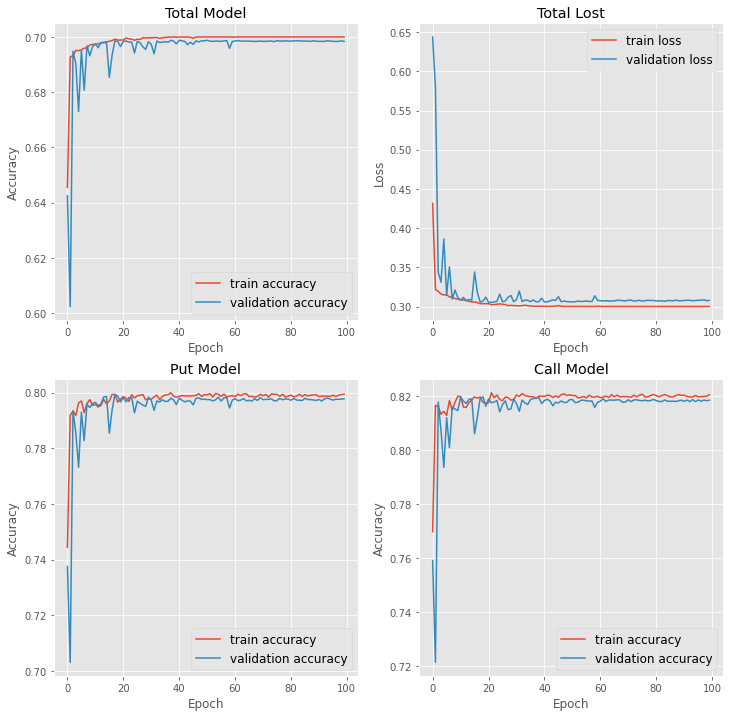

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(train[1])
plt.plot(train[3])
plt.title('Total Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

# plt.clf()
plt.subplot(2,2,2)
plt.plot(train[0])
plt.plot(train[2])
plt.title('Total Lost')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

plt.subplot(2,2,3)
plt.plot(traind_put[1])
plt.plot(traind_put[3])
plt.title('Put Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,4)
plt.plot(traind_call[1])
plt.plot(traind_call[3])
plt.title('Call Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.savefig('./data/out_pic/Total.pdf')
#plt.show()

In [ ]:
'''画图'''
import pandas as pd
import os
import numpy as np
import pyecharts.options as opts
from pyecharts.charts import Line

output_folder = r'.\data\out'
csv_list = os.listdir(output_folder)

datall = []
for datafile in csv_list:
    csv_path = output_folder +"\\"+datafile
    data = pd.read_csv(csv_path, encoding = 'utf-8', index_col= False)
    data = list(data['iv'])
    print(data)
    datall.append(data)

x = list(range(1,len(data)+1))

line = (
    Line()
    .add_xaxis(xaxis_data=x)
    .add_yaxis(series_name="y1线",y_axis=datall[0],symbol="arrow",is_symbol_show=True)
    .add_yaxis(series_name="y2线",y_axis=datall[1])
    .set_global_opts(title_opts=opts.TitleOpts(title="Line-多折线重叠"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)
line.render('./data/out_pic/'+ '重叠' + '.html')
datall

In [41]:
'''画图'''
import pandas as pd
import os
import numpy as np
import pyecharts.options as opts
from pyecharts.charts import Line

output_folder = r'.\data\out'
csv_list = os.listdir(output_folder)

datall = []
for datafile in csv_list:
    csv_path = output_folder +"\\"+datafile
    data = pd.read_csv(csv_path, encoding = 'utf-8', index_col= False)
    data = list(data['iv'])
    print(data)
    datall.append(data)

x = list(range(1,len(data)+1))

line = (
    Line()
    .add_xaxis(xaxis_data=x)
    .add_yaxis(series_name="y1线",y_axis=datall[0],symbol="arrow",is_symbol_show=True, is_smooth=True)
    .add_yaxis(series_name="y2线",y_axis=datall[1], is_smooth=True)
    .set_global_opts(title_opts=opts.TitleOpts(title="Line-折线平滑重叠"))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
)
line.render('./data/out_pic/'+ 'smooth' + '.html')
datall


[0.3926388671875, 0.378968359375, 0.3574861328125, 0.3467450195312499, 0.30475703125, 0.34967441406249994, 0.3418626953125, 0.3067099609375, 0.00010000000000000002, 0.31647460937499994, 0.31256874999999995, 0.308662890625, 0.2871806640624999, 0.30475703125, 0.3067099609375, 0.00010000000000000002, 0.31256874999999995, 0.18758125, 0.35162734374999993, 0.00010000000000000002, 0.00010000000000000002, 0.00010000000000000002, 0.00010000000000000002, 0.7031546874999999, 0.00010000000000000002, 0.00010000000000000002, 1.0, 0.00010000000000000002]
[0.37603896484375, 0.3545567382812499, 0.34283916015624993, 0.32819218749999995, 0.3028041015625, 0.31842753906249993, 0.3067099609375, 0.2881571289062499, 0.269604296875, 0.34967441406249994, 0.2656984375, 0.3028041015625, 0.3154981445312499, 0.29694531249999995, 0.3154981445312499, 0.238357421875, 0.28522773437499993, 0.21101640625, 0.300851171875, 0.00010000000000000002, 0.00010000000000000002, 0.00010000000000000002, 0.00010000000000000002, 0.000

[[0.3926388671875,
  0.378968359375,
  0.3574861328125,
  0.3467450195312499,
  0.30475703125,
  0.34967441406249994,
  0.3418626953125,
  0.3067099609375,
  0.00010000000000000002,
  0.31647460937499994,
  0.31256874999999995,
  0.308662890625,
  0.2871806640624999,
  0.30475703125,
  0.3067099609375,
  0.00010000000000000002,
  0.31256874999999995,
  0.18758125,
  0.35162734374999993,
  0.00010000000000000002,
  0.00010000000000000002,
  0.00010000000000000002,
  0.00010000000000000002,
  0.7031546874999999,
  0.00010000000000000002,
  0.00010000000000000002,
  1.0,
  0.00010000000000000002],
 [0.37603896484375,
  0.3545567382812499,
  0.34283916015624993,
  0.32819218749999995,
  0.3028041015625,
  0.31842753906249993,
  0.3067099609375,
  0.2881571289062499,
  0.269604296875,
  0.34967441406249994,
  0.2656984375,
  0.3028041015625,
  0.3154981445312499,
  0.29694531249999995,
  0.3154981445312499,
  0.238357421875,
  0.28522773437499993,
  0.21101640625,
  0.300851171875,
  0.0001

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten


# design network
def model():
    model = Sequential()
    model.add(Conv1D(32, 2, padding='valid', input_shape=(10,10), activation="relu"))
    model.add(Conv1D(62, 2, padding='valid', activation="relu"))
    model.add(Conv1D(128, 2, padding='valid', activation="relu"))
    model.add(Conv1D(256, 2, padding='valid', activation="relu"))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    return model

10000001.csv
2.331 2.2 0.045769000000000004
0.32043169631333
2.369 2.2 0.045696
0.3080317259070162
2.38 2.2 0.045715000000000006
0.2887274702034497
2.384 2.2 0.045540000000000004
0.2795703340828702
2.39 2.2 0.045669
0.24327669072354502
2.394 2.2 0.045716
0.2818393382060567
2.411 2.2 0.045626
0.27386953254299873
2.37 2.2 0.04592399999999999
0.24612747202890248
2.45

f:\annacoda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 2.2 0.046345
0.20160753627707947
2.438 2.2 0.046482
0.2489673682887767
2.441 2.2 0.046612
0.24284978875914873
2.364 2.2 0.046759
0.24981262557479547
2.362 2.2 0.046664000000000004
0.23158712232781736
2.334 2.2 0.046856999999999996
0.24895854002801304
2.339 2.2 0.047095000000000005
0.2506257773283445
2.397 2.2 0.047596
0.2197794869617965
2.359 2.2 0.047313
0.2549227846671918
2.374 2.2 0.047008999999999995
0.13487229687291505
2.448 2.2 0.04702
0.2846230173494816
2.455 2.2 0.046981999999999996
0.2250481083195846


f:\annacoda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
f:\annacoda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
f:\annacoda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


2.51 2.2 0.047459
nan
2.543 2.2 0.047672
nan
2.611 2.2 0.047207
24.05286671838681
2.587 2.2 0.047304000000000006
0.5
2.635 2.2 0.046605
2.830175391479184
2.676 2.2 0.046715
nan
2.638 2.2 0.046692
0.9106970618646787
2.604 2.2 0.046925999999999995
11.598611434669412


In [ ]:
def model1():
    model = Sequential()
    model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    return model1
